In [22]:
import numpy as np
import mne
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import pickle


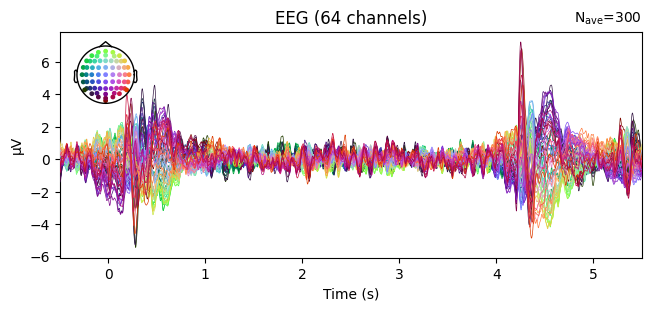

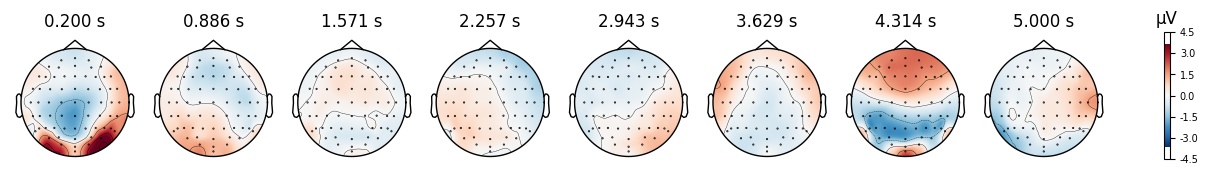

In [23]:
epochs = mne.read_epochs("data/301A_FG_preprocessed-epo.fif", preload=True)
epochs.average().plot()
epochs.average().plot_topomap(times=np.linspace(0.2,5,8), ch_type="eeg", show=False)


plt.show()

In [24]:
epochs = mne.read_epochs("data/301A_FG_preprocessed-epo.fif", preload=True)

epochs_resampled = epochs.copy().resample(200)

data_resampled = epochs_resampled.get_data()

print(f'Resampled EEG shape: {data_resampled.shape}')

Reading /Users/rasmusarnmark/Desktop/Sem4/fagprojekt/fagprojekt/data/301A_FG_preprocessed-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    5498.00 ms
        0 CTF compensation matrices available
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Resampled EEG shape: (300, 64, 1200)


In [25]:
labels = epochs.events[:,-1]
binary_labels = np.array([0 if l in [301, 303, 305, 307, 309] else 1 for l in labels])

# Load a pickle file
with open("data/FG_overview_df_v2.pkl", "rb") as file:
    data = pickle.load(file)

print(type(data))  # Check the type of the loaded object
data  # Print the contents



<class 'pandas.core.frame.DataFrame'>


,Subject_id,Exp_id,Friend_status,EEG_device,Force_device,Force_port,Age,Gender,Class_friends,Class_close_friends,Friends,Close_friends,Triad_id,Participant,tFriends,tClose_friends,All_friends,tClass,rClass
0,1049,301A,Yes,1,1,1,22.239562,F,3,6,9,14,301,P1,12,20,32,9,0.666667
1,1029,301B,No,2,3,2,24.331280,M,3,1,8,5,301,P2,11,6,17,4,0.250000
2,1028,301C,Yes,3,4,3,21.670089,M,8,4,9,4,301,P3,17,8,25,12,0.333333
3,1064,302A,Yes,1,1,1,22.009582,M,14,8,11,5,302,P1,25,13,38,22,0.363636
4,1024,302B,Yes,2,3,2,21.355236,M,5,7,6,10,302,P2,11,17,28,12,0.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,6069,330B,No,2,3,2,19.373032,F,14,3,17,17,330,P2,31,20,51,17,0.176471
88,6048,330C,Yes,3,4,3,19.841205,M,13,11,25,26,330,P3,38,37,75,24,0.458333
89,6015,331A,Yes,1,1,1,20.052019,M,9,4,14,13,331,P1,23,17,40,13,0.307692
90,6183,331B,Yes,2,3,2,18.863792,M,22,6,25,12,331,P2,47,18,65,28,0.214286


In [26]:
import torch
import mne
import numpy as np
import glob
import pandas as pd

# Load metadata DataFrame
df_info = pd.read_pickle("data/FG_overview_df_v2.pkl")  # Update with actual path

# Define event IDs
event_labels = {'T1P': 301, 'T1Pn': 302, 'T3P': 303, 'T3Pn': 304,
                'T12P': 305, 'T12Pn': 306, 'T13P': 307, 'T13Pn': 308,
                'T23P': 309, 'T23Pn': 310}

file_paths = glob.glob("data/*_FG_preprocessed-epo.fif")  # Update with actual data path
print(f"Found {len(file_paths)} EEG files.")

all_eeg_data, all_labels = [], []

for file_path in file_paths[:1]:
    # Extract filename (e.g., "301A")
    file_name = file_path.split("/")[-1].split("_")[0]  # Extract "301A"

    # Extract Experiment ID (e.g., "301")
    exp_id = file_name[:4]

    # Get participants for this experiment
    experiment_participants = df_info[df_info["Exp_id"] == exp_id]

    if experiment_participants.empty:
        print(f"Skipping {file_name}: No participants found for {exp_id}.")
        continue

    # Load EEG file
    epochs = mne.read_epochs(file_path, preload=True)
    epochs.resample(200)
    eeg_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
    labels = epochs.events[:, -1]  # Extract event labels

    # Process each participant in the experiment
    for _, row in experiment_participants.iterrows():
        subject_id = row["Subject_id"]
        eeg_device = row["EEG_device"]  # 1, 2, or 3

        # Map EEG device to the corresponding event labels
        device_event_labels = {
            1: {301, 302, 305, 306, 307, 308},  # T1 labels
            2: {303, 304, 305, 306, 309, 310},  # T2 labels
            3: {307, 308, 309, 310, 303, 304},  # T3 labels
        }

        valid_events = device_event_labels[eeg_device]

        # Filter trials for this subject
        valid_trials = [i for i, label in enumerate(labels) if label in valid_events]

        if len(valid_trials) == 0:
            print(f"Skipping subject {subject_id} in {exp_id}: No relevant trials for EEG device {eeg_device}.")
            continue

        # Keep only the relevant trials
        eeg_subject_data = eeg_data[valid_trials]
        labels_subject = labels[valid_trials]

        # Normalize per file
        eeg_subject_data = (eeg_subject_data - eeg_subject_data.mean()) / eeg_subject_data.std()

        # Convert labels to binary classification (feedback vs. no feedback)
        binary_labels = np.array([1 if label in {301, 303, 305, 307, 309} else 0 for label in labels_subject])

        all_eeg_data.append(eeg_subject_data)
        all_labels.append(binary_labels)

# Convert to PyTorch tensors
eeg_tensor = torch.tensor(np.concatenate(all_eeg_data, axis=0), dtype=torch.float32)
labels_tensor = torch.tensor(np.concatenate(all_labels, axis=0), dtype=torch.long)

num_patches = 6  # Choose the number of patches
time_steps_per_patch = eeg_tensor.shape[2] // num_patches  # Divide time into patches

print(eeg_tensor.shape)
# Reshape EEG tensor
eeg_tensor = eeg_tensor.reshape(eeg_tensor.shape[0], eeg_tensor.shape[1], num_patches, time_steps_per_patch)
eeg_tensor.shape

print(f"Final EEG Tensor Shape: {eeg_tensor.shape}")


Found 15 EEG files.
torch.Size([180, 64, 1200])
Final EEG Tensor Shape: torch.Size([180, 64, 6, 200])


In [27]:
epochs = mne.read_epochs(file_paths[0])
labels = epochs.info['ch_names']
electrode_names = [l.upper() for l in labels]

Reading /Users/rasmusarnmark/Desktop/Sem4/fagprojekt/fagprojekt/data/303A_FG_preprocessed-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    5498.00 ms
        0 CTF compensation matrices available
Not setting metadata
298 matching events found
No baseline correction applied
0 projection items activated


In [30]:
eeg_tensor.shape, labels_tensor.shape

(torch.Size([180, 64, 6, 200]), torch.Size([180]))

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torcheeg.models import LaBraM

# Define EEG Dataset class
class EEGDataset(Dataset):
    def __init__(self, eeg_data, labels):
        self.eeg_data = eeg_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.eeg_data[idx], self.labels[idx]

# Convert dataset to PyTorch Dataset format
dataset = EEGDataset(eeg_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


# Initialize LabRam Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LaBraM(in_channels=len(electrode_names), num_classes=2).to(device)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        print(inputs.shape)

        optimizer.zero_grad()
        outputs = model(inputs, electrodes=electrode_names)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")

print("Training Complete!")


torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([4, 64, 6, 200])
Epoch [1/10], Loss: 0.7299
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([4, 64, 6, 200])
Epoch [2/10], Loss: 0.6992
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 6, 200])
torch.Size([16, 64, 

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# Save the trained model
torch.save(model.state_dict(), "eeg_labram_model.pth")

# Evaluation
model.eval()
all_preds = []
all_labels = []

# Create test dataloader - using 20% of data for testing

# Generate indices for train and test
indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42, stratify=labels_tensor)

# Create test dataset and dataloader
test_dataset = Subset(dataset, test_indices)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate
with torch.no_grad():
    correct = 0
    total = 0
    
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs, electrodes=electrode_names)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

# Confusion matrix and classification report

# Convert to numpy arrays for sklearn
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate and display confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Feedback', 'Feedback'],
            yticklabels=['No Feedback', 'Feedback'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, 
                           target_names=['No Feedback', 'Feedback']))

In [ ]:
import torcheeg.models as models
print(dir(models))  # Lists all available models

l = ['FP1', 'FPZ', 'FP2', 'AF9', 'AF7', 'AF5', 'AF3', 'AF1', 'AFZ', 'AF2', 'AF4', 'AF6', 'AF8', 'AF10', 'F9', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'F10', 'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'T9', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'T10', 'TP9', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'P9', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO9', 'PO7', 'PO5', 'PO3', 'PO1', 'POZ', 'PO2', 'PO4', 'PO6', 'PO8', 'PO10', 'O1', 'OZ', 'O2', 'O9', 'CB1', 'CB2', 'IZ', 'O10', 'T3', 'T5', 'T4', 'T6', 'M1', 'M2', 'A1', 'A2', 'CFC1', 'CFC2', 'CFC3', 'CFC4', 'CFC5', 'CFC6', 'CFC7', 'CFC8', 'CCP1', 'CCP2', 'CCP3', 'CCP4', 'CCP5', 'CCP6', 'CCP7', 'CCP8', 'T1', 'T2', 'FTT9h', 'TTP7h', 'TPP9h', 'FTT10h', 'TPP8h', 'TPP10h', 'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2']
len(l)

['ATCNet', 'ArjunViT', 'BCDecoder', 'BCDiscriminator', 'BCEncoder', 'BCGenerator', 'BCGlow', 'BCUNet', 'BDecoder', 'BDiscriminator', 'BEncoder', 'BGenerator', 'BGlow', 'BUNet', 'CCNN', 'CSPNet', 'Conformer', 'DGCNN', 'DeepSleepNet', 'EEGNet', 'EEGfuseNet', 'EFDiscriminator', 'F', 'FBCCNN', 'FBCNet', 'FBMSNet', 'GIN', 'GRU', 'LGGNet', 'LMDA', 'LSTM', 'LaBraM', 'MTCNN', 'RGNN', 'SSTEmotionNet', 'STNet', 'SimpleViT', 'TCNet', 'TSCeption', 'TSLANet', 'TinySleepNet', 'Tuple', 'USleep', 'VanillaTransformer', 'ViT', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'arjun_vit', 'atcnet', 'bcddpm', 'bcgan', 'bcglow', 'bcvae', 'bddpm', 'bgan', 'bglow', 'bvae', 'ccnn', 'cnn', 'conformer', 'cspnet', 'ddpm', 'deep_sleepnet', 'dgcnn', 'eegfusenet', 'eegnet', 'fbccnn', 'fbcnet', 'fbmsnet', 'flow', 'gan', 'gin', 'gnn', 'gru', 'labram', 'lggnet', 'lmda', 'lstm', 'mtcnn', 'nn', 'rgnn', 'rnn', 'simple_vit', 'sst_emotion_net', 'stnet', '

136